#  Bayesian Regression

##### Keywords: bayesian, regression, normal-normal model, bayesian updating, conjugate prior

$$
\renewcommand{\like}{\cal L}
\renewcommand{\loglike}{\ell}
\renewcommand{\err}{\cal E}
\renewcommand{\dat}{\cal D}
\renewcommand{\hyp}{\cal H}
\renewcommand{\Ex}[2]{E_{#1}[#2]}
\renewcommand{\x}{\mathbf x}
\renewcommand{\v}[1]{\mathbf #1}
$$

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
from scipy.stats import norm
from scipy.stats import multivariate_normal
def cplot(f, ax=None):
    if not ax:
        plt.figure(figsize=(4,4))
        ax=plt.gca()
    xx,yy=np.mgrid[-1:1:.01,-1:1:.01]
    pos = np.empty(xx.shape + (2,))
    pos[:, :, 0] = xx
    pos[:, :, 1] = yy
    ax.contourf(xx, yy, f(pos))
    #data = [x, y]
    return ax
def plotSampleLines(mu, sigma, numberOfLines, dataPoints=None, ax=None):
    #Plot the specified number of lines of the form y = w0 + w1*x in [-1,1]x[-1,1] by
    # drawing w0, w1 from a bivariate normal distribution with specified values
    # for mu = mean and sigma = covariance Matrix. Also plot the data points as
    # blue circles. 
    #print "datap",dataPoints
    if not ax:
        plt.figure()
        ax=plt.gca()
    for i in range(numberOfLines):
        w = np.random.multivariate_normal(mu,sigma)
        func = lambda x: w[0] + w[1]*x
        xx=np.array([-1,1])
        ax.plot(xx,func(xx),'r', alpha=0.2)
    if dataPoints:
        ax.scatter(dataPoints[0],dataPoints[1])
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])


## The Bayesian formulation of regression

Let us say we have data $D$, of $n$ observations  
$D=\left\{ ({\bf x}_1, y_1), ({\bf x}_2,y_2), \ldots, ({\bf x}_n, y_n) \right\} $ where ${\bf x}$ 
denotes an input vector of dimension $D$ and $y$ denotes a scalar output (dependent variable). 
All data points are combined into a $D \times n$ matrix $X$. 
The model that determines the relationship between inputs and 
output is given by

$$ y   = \bf x^{T} {\bf w} + \epsilon $$

where ${\bf w}$ is a vector of parameters of the linear model. Usually there is 
a bias or offset is included, but for now we ignore it. 

We assume that the additive noise  $\epsilon$ is iid Gaussian with
zero mean and variance $\sigma_n^2$ 

$$ \epsilon \sim N(0, \sigma^2_n) $$

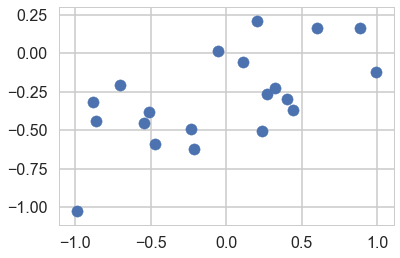

In [3]:
a0=-0.3
a1=0.5
N=20
noiseSD=0.2
u=np.random.rand(20)
x=2.*u -1.
def randnms(mu, sigma, n):
    return sigma*np.random.randn(n) + mu
y=a0+a1*x+randnms(0.,noiseSD,N)
plt.scatter(x,y)

### Likelihood

The likelihood is, because we assume independency, the product 

$$
\begin{eqnarray} \like &=& p(\bf y|X,\bf w) = \prod_{i=1}^{n} p(y_i|\bf X_i, \bf w) =   \prod_{i=1}^{n}  \frac{1}{\sqrt{2\pi}\sigma_n}
   \exp{ \left( -\frac{(y_i-\bf X_i^T \bf w)^2}{2\sigma_n^2} \right)}  \nonumber \\ 
   &\propto &  \exp{\left( -\frac{| \bf y-X^T \bf w|^2 }{2\sigma_n^2} \right)} \propto N(X^T \bf w,  \sigma_n^2 I)
\end{eqnarray}
$$
   
where $|x|$ denotes the Euclidean length of vector $\bf x$. 

In [4]:
likelihoodSD = noiseSD # Assume the likelihood precision is known.
likelihoodPrecision = 1./(likelihoodSD*likelihoodSD)

### Prior

In the Bayesian framework inference we need to specify a prior
over the parameters that expresses our belief about the parameters
before we take any measurements. A wise choice is a ${\bf w_0}$ mean 
Gaussian with covariance matrix $\Sigma$ 

$$
 \bf w \sim N(w_0, \Sigma) 
$$

If we assume that $\Sigma$ is a diagonal covariance matrix then

$$\bf w \sim N(w_0, \tau^2 \bf I)$$

In [5]:
priorMean = np.zeros(2)
priorPrecision=2.0
prior_covariance = lambda alpha: alpha*np.eye(2)#Covariance Matrix
priorCovariance = prior_covariance(1/priorPrecision )
priorPDF = lambda w: multivariate_normal.pdf(w,mean=priorMean,cov=priorCovariance)
priorPDF([1,2])

0.0021447551423913074

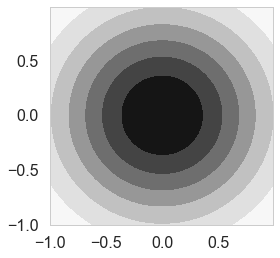

In [6]:
cplot(priorPDF);

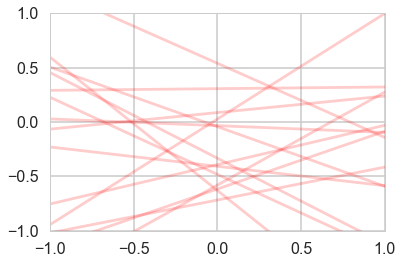

In [7]:
plotSampleLines(priorMean,priorCovariance,15)

### Posterior
We can now continue with the standard Bayesian formalism 

$$
\begin{eqnarray}
 p(\bf w| \bf y,X) &\propto& p(\bf y | X, \bf w) \, p(\bf w) \nonumber \\
                       &\propto& \exp{ \left(- \frac{1}{2 \sigma_n^2}(\bf y-X^T \bf w)^T(\bf y - X^T \bf w) \right)}
                        \exp{\left( -\frac{1}{2} \bf w^T \Sigma^{-1} \bf w \right)}  \nonumber \\ 
\end{eqnarray}
$$
 
In the next step we `complete the square' and obtain 

\begin{equation}
p(\bf w| \bf y,X)  \propto  \exp \left( -\frac{1}{2} (\bf w - \bar{\bf w})^T  (\frac{1}{\sigma_n^2} X X^T + \Sigma^{-1})(\bf w - \bar{\bf w} )  \right)
\end{equation}

This is a Gaussian with inverse-covariance

$$A= \sigma_n^{-2}XX^T +\Sigma^{-1}$$

where the new mean is

$$\bar{\bf w} = A^{-1}\Sigma^{-1}{\bf w_0} + \sigma_n^{-2}( A^{-1} X^T \bf y )$$



To make predictions for a test case we average over all possible parameter predictive distribution
values, weighted by their posterior probability. This is in contrast to non Bayesian schemes, where a single parameter is typically chosen by some criterion. 

In [8]:
# Given the mean = priorMu and covarianceMatrix = priorSigma of a prior
# Gaussian distribution over regression parameters; observed data, x
# and y; and the likelihood precision, generate the posterior
# distribution, postW via Bayesian updating and return the updated values
# for mu and sigma. xtrain is a design matrix whose first column is the all
# ones vector.
def update(x,y,likelihoodPrecision,priorMu,priorCovariance): 
    postCovInv  = np.linalg.inv(priorCovariance) + likelihoodPrecision*np.outer(x.T,x)
    #The outer product looks wrong but when updating we need a 2x1 matrix while x is 1x2
    postCovariance = np.linalg.inv(postCovInv)
    postMu = np.dot(np.dot(postCovariance,np.linalg.inv(priorCovariance)),priorMu) + likelihoodPrecision*np.dot(postCovariance,np.outer(x.T,y)).flatten()
    postW = lambda w: multivariate_normal.pdf(w,postMu,postCovariance)
    return postW, postMu, postCovariance

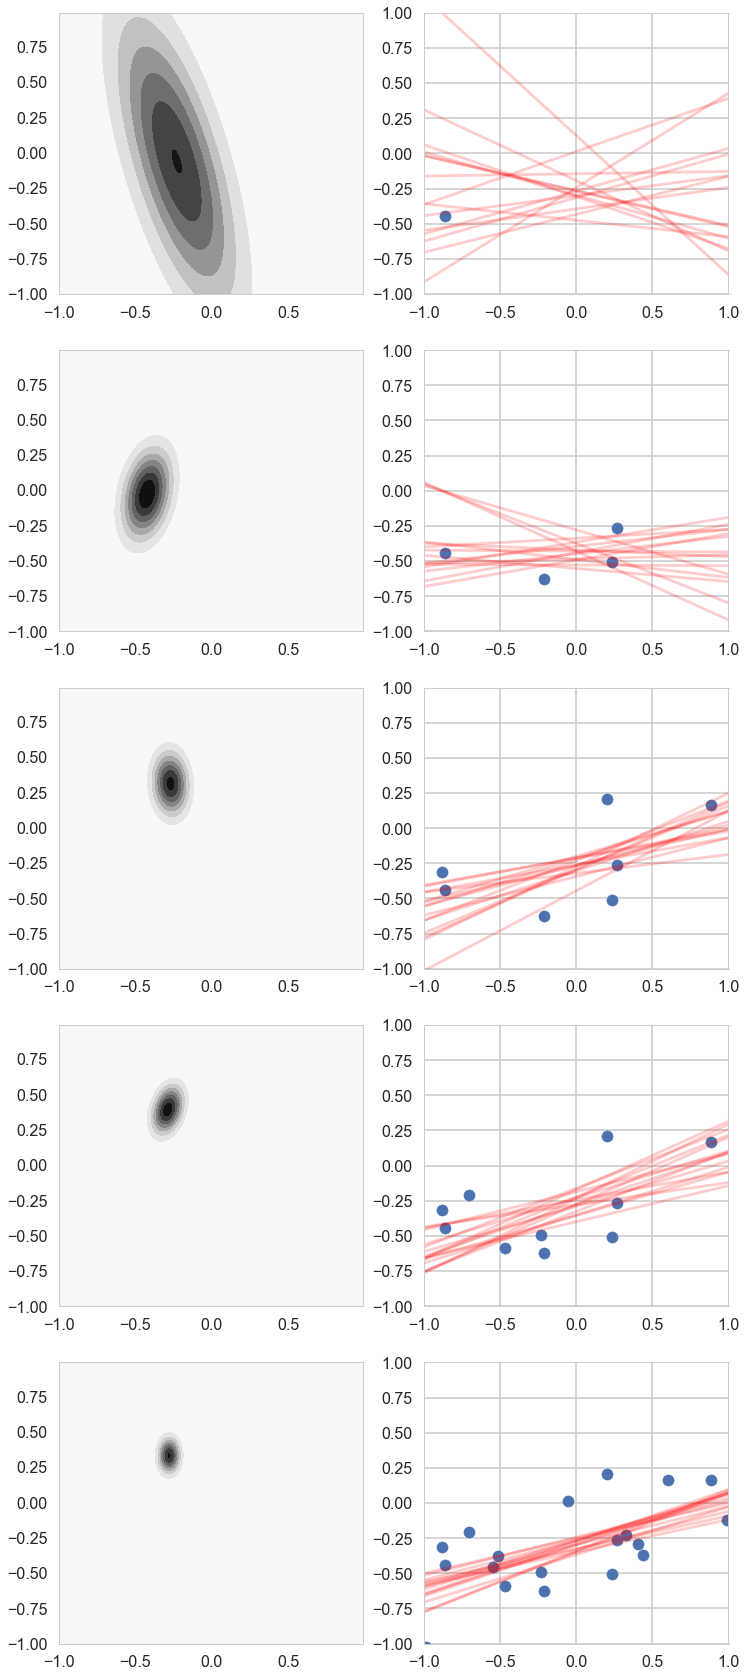

In [9]:
# For each iteration plot  the
# posterior over the first i data points and sample lines whose
# parameters are drawn from the corresponding posterior. 
fig, axes=plt.subplots(figsize=(12,30), nrows=5, ncols=2);
mu = priorMean
cov = priorCovariance
muhash={}
covhash={}
k=0
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]:
    postW,mu,cov = update(np.array([1,x[i]]),y[i],likelihoodPrecision,mu,cov)
    muhash[i]=mu
    covhash[i]=cov
    if i in [1,4,7,10,19]:
        cplot(postW, axes[k][0])
        plotSampleLines(muhash[i],covhash[i],15, (x[0:i],y[0:i]), axes[k][1])
        k=k+1


## Posterior Predictive Distribution

Thus the predictive distribution at some $x^{*}$ is given by averaging the output of all possible linear models w.r.t. the  posterior

$$
\begin{eqnarray} 
p(y^{*} | x^{*}, {\bf x,y}) &=& \int p({\bf y}^{*}| {\bf x}^{*}, {\bf w} ) p(\bf w| X, y)dw \nonumber \\
                                    &=& {\cal N} \left(y \vert \bar{\bf w}^{T}x^{*}, \sigma_n^2 + x^{*^T}A^{-1}x^{*} \right),
\end{eqnarray}
$$


which is again Gaussian, with a mean given by the posterior mean multiplied by the test input
and the variance is a quadratic
form of the test input with the posterior covariance matrix, showing that the
predictive uncertainties grow with the magnitude of the test input, as one would
expect for a linear model. 

## Regularization

$\alpha = \sigma_n^2/\tau^2$ (prior precision/likelihood precision) is the regularization parameter from ridge regression. An uninformative (tending to uniform) prior means no regularization which is the standard MLE result.


In [10]:
priorPrecision/likelihoodPrecision

0.08000000000000002

But now say you had a  strong belief the both the slope and intercept ought to be 0. Or in other words you are trying to restrict your parameters to a certain range.

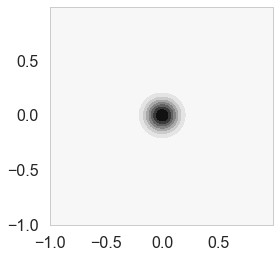

In [11]:
priorPrecision=100.0
priorCovariance = prior_covariance(1/priorPrecision )
priorPDF = lambda w: multivariate_normal.pdf(w,mean=priorMean,cov=priorCovariance)
cplot(priorPDF)

In [12]:
priorPrecision/likelihoodPrecision

4.000000000000001

In [13]:
choices=np.random.choice([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],4,replace=False)

In [14]:
choices

array([ 1, 18, 13, 19])

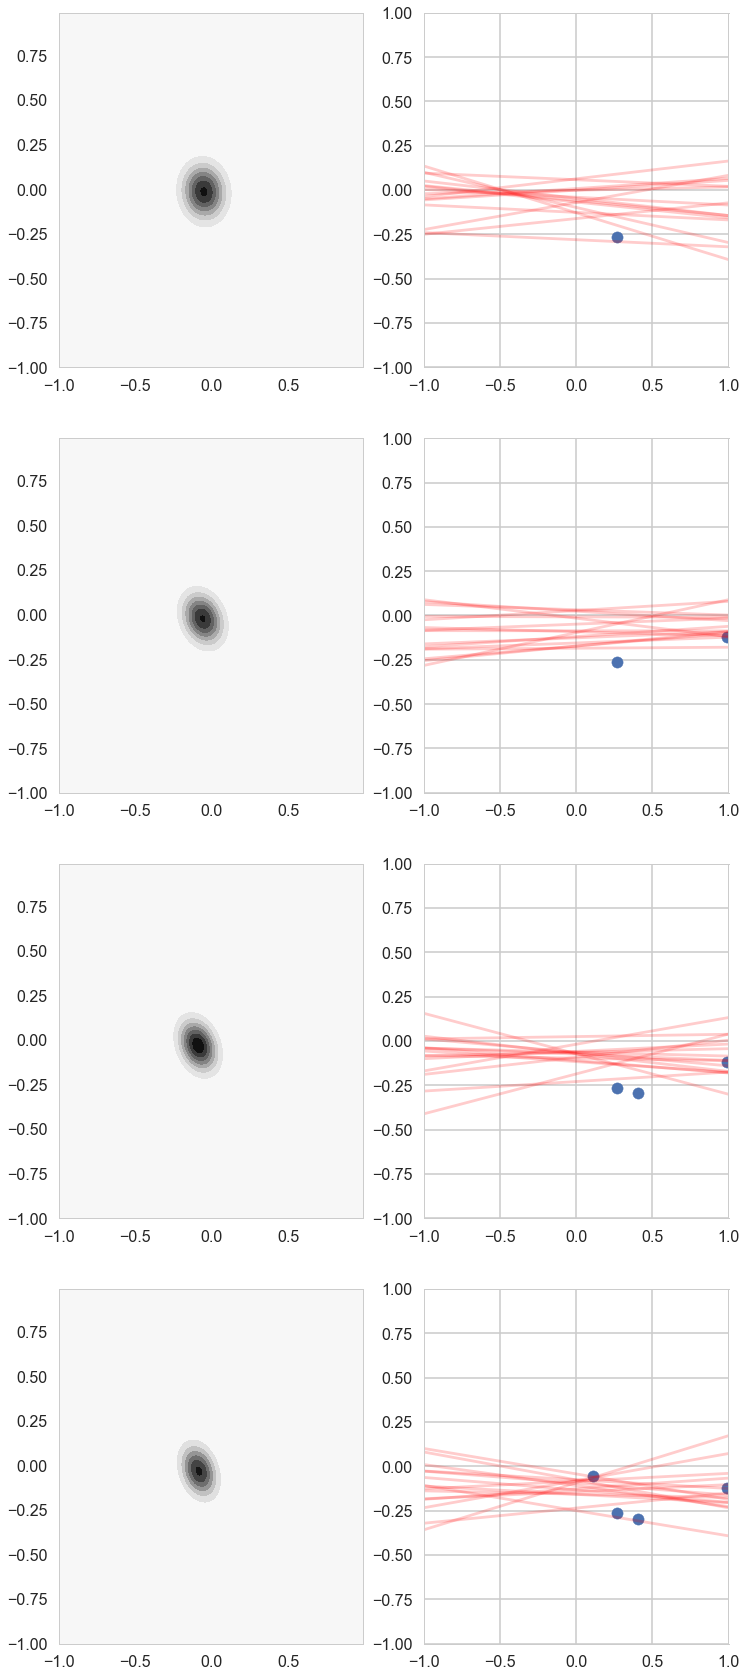

In [15]:

# For each iteration plot  the
# posterior over the first i data points and sample lines whose
# parameters are drawn from the corresponding posterior. 
fig, axes=plt.subplots(figsize=(12,30), nrows=4, ncols=2);
mu = priorMean
cov = priorCovariance
muhash={}
covhash={}
k=0
xnew=x[choices]
ynew=y[choices]
for j,i in enumerate(choices):
    postW,mu,cov = update(np.array([1,xnew[j]]),ynew[j],likelihoodPrecision,mu,cov)
    muhash[i]=mu
    covhash[i]=cov
    cplot(postW, axes[k][0])
    plotSampleLines(muhash[i],covhash[i],15, (xnew[:j+1],ynew[:j+1]), axes[k][1])
    k=k+1



Notice how our prior tries to keep things as flat as possible!